In [24]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

Skipping install of 'rwwa' from a github remote, the SHA1 (d52021fc) has not changed since last install.
  Use `force = TRUE` to force installation



# Fitted models - rainy season precip

## Results for synthesis

In [25]:
datasets <- c("chirps","era5land", "mswep")

In [26]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [27]:
for (ds in datasets) {
    
    fnm <- paste0("ts/panama_pr-rs_",ds,".dat")
    
    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res_", fnm))
    if(!file.exists(res_fnm)) {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        df <- merge(merge(gmst, nino), ts)

        mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
        res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000)

        write.csv(res, res_fnm)
    }
}

In [28]:
# load all the bootstrapped results
res_rs <- abind::abind(sapply(datasets, function(ds) {
    read.csv(paste0("res/res_panama_pr-rs_",ds,".csv"), row.names = "X")
}, simplify = F), along = 0)
res_rs[c("era5land"),"return_period",] <- NA

In [30]:
fnm

[1] "ts/panama_pr-rs_mswep.dat"

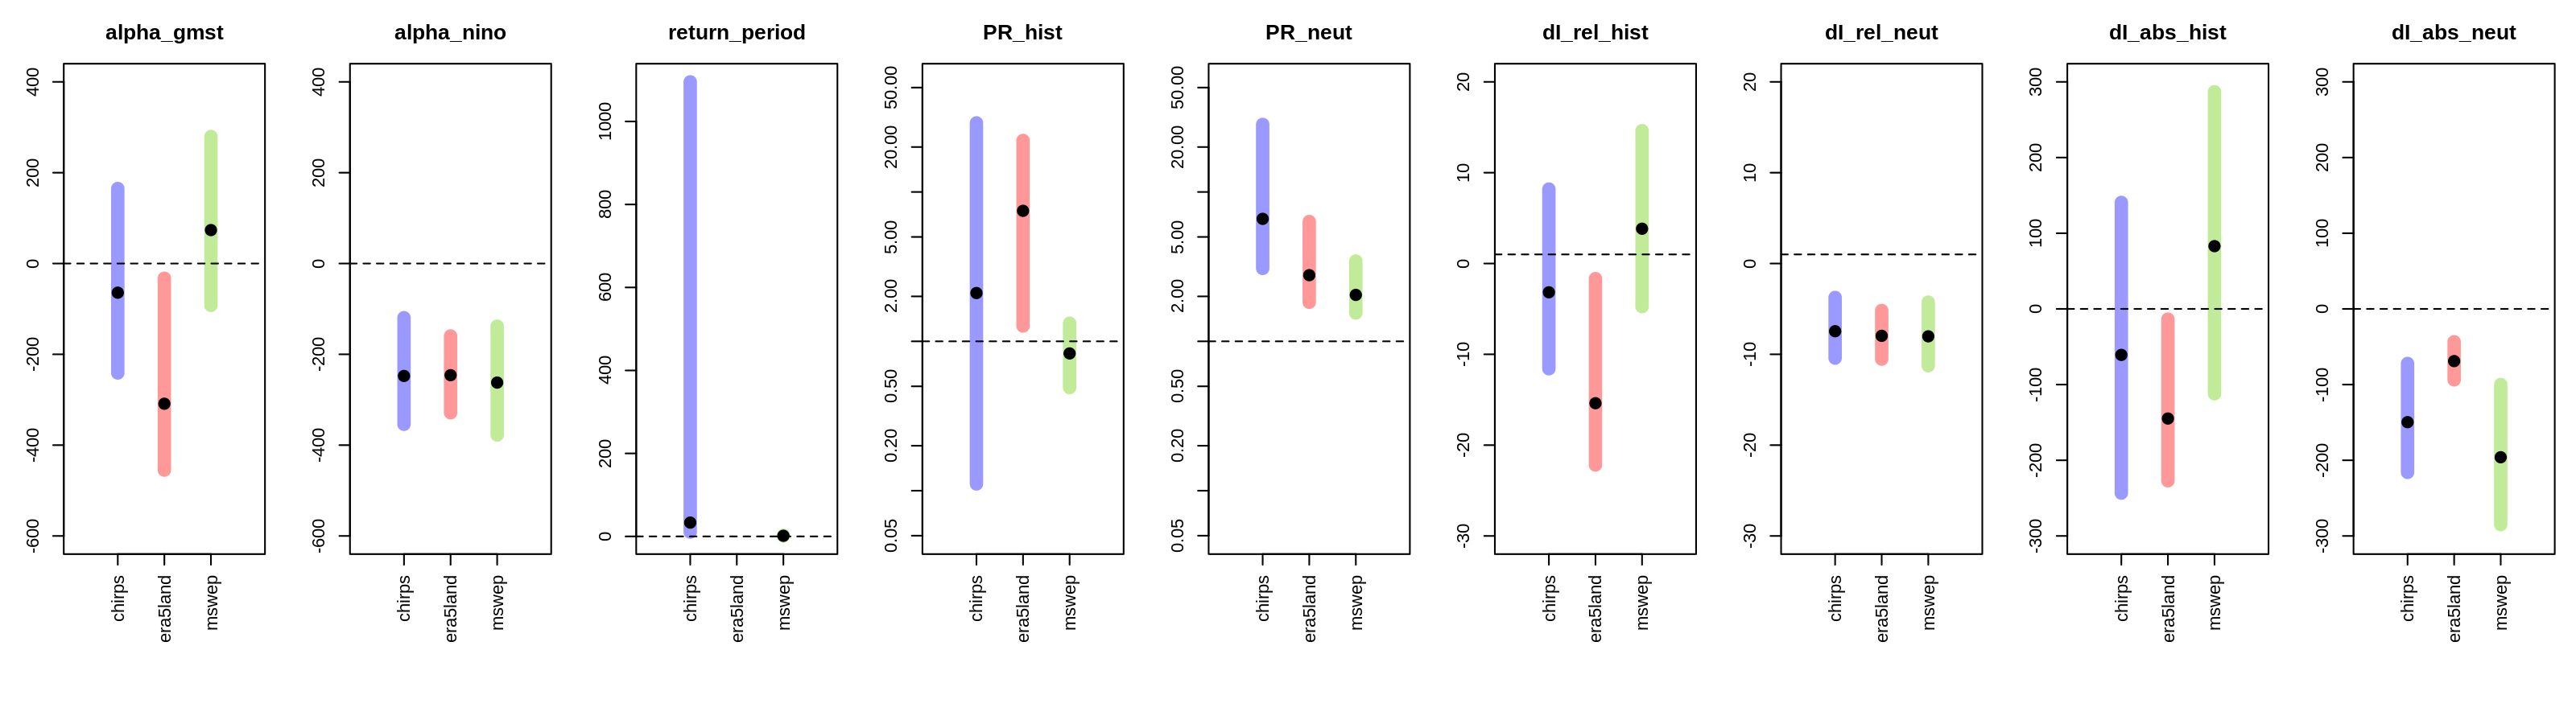

In [23]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- res_rs[,r,]
        ylim = range(res, na.rm = T)
        logaxs = ""
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(res_rs[,grepl("alpha", colnames(res_rs)),]))
        } else if(grepl("dI_abs", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_abs", colnames(res_rs)),]))
            h = 0
        } else if(grepl("dI_rel", r)) {
            ylim = range(pretty(res_rs[,grepl("dI_rel", colnames(res_rs)),]))
        } else if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(res_rs[,grepl("PR", colnames(res_rs)),]))))
        } else {
            h = 0
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"X2.5."], y1 = res[,"X97.5."], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

## Per grid cell

In [7]:
ds <- "era5land"

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv(paste0("data/",ds,"_pr-MJJASOND_flattened.csv"), skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [8]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "fixeddisp", df_c, cnm, c("gmst", "nino"), lower = T)
}, simplify = F)

In [9]:
# get all model resuls & save as .csv to be reconstructed & plotted in python
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_rs_",ds,"-gridded.csv"))

## Individual stations

In [5]:
# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

### Filled stations

In [13]:
# specify period to fit model to
ys <- 1925

# load station data, combine with covariates in single dataframe
pr <- read.csv("data/acp-filled_pr-rs.csv", row.names = "Date")
pr$year <- rownames(pr)
df <- merge(merge(gmst, nino), pr)

In [14]:
# fit all the models
models <- list()
for(stn in colnames(df)[-(1:3)]) {
    df_stn <- df[df$year >= ys,c("year", "gmst", "nino", stn)]
    models[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}

# get all the best estimates & save as single file
res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res <- rbind(res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop = F])))
write.csv(res, paste0("res/res_rs_stations-filled_",ys,"-2023.csv"))

### Mostly-complete stations

In [15]:
# specify period to fit model to
ys <- 1925

# load station data, combine with covariates in single dataframe
pr <- read.csv("data/acp-complete_pr-rs.csv", row.names = "X")
pr$year <- rownames(pr)
df <- merge(merge(gmst, nino), pr)

# filter to only required period
df <- df[df$year >= ys,]

# select only stations with more than 90% complete years
complete_stations <- names(which(colSums(!is.na(df[,-(1:3)])) > ceiling((2023-ys) * .9)))
df <- df[,c("year", "gmst", "nino", complete_stations)]

In [16]:
# fit models to the available data
models <- list()
for(stn in colnames(df)[-(1:3)]) {
    df_stn <- df[df$year >= ys,c("year", "gmst", "nino", stn)]
    models[[stn]] <- fit_ns("norm", "fixeddisp", df_stn[!is.na(df_stn[,stn]),], stn, c("gmst", "nino"), lower = T)
}

# get all the best estimates & save as single file
res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res <- rbind(res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop = F])))
write.csv(res, paste0("res/res_rs_stations-complete_",ys,"-2023.csv"))

### Compare results when using complete years vs gap-filled data

In [19]:
ys <- 1979

res_complete <- read.csv(paste0("res/res_rs_stations-complete_",ys,"-2023.csv"), row.names = "X")
res_filled <- read.csv(paste0("res/res_rs_stations-filled_",ys,"-2023.csv"), row.names = "X")

# find stations that appear in both datasets, combine into a single array of all results
stations <- names(which(sapply(colnames(res_complete), function(cnm) cnm %in% colnames(res_filled))))
                               
res_all <- abind::abind("complete" = res_complete[,stations], "filled" = res_filled[,stations], along = 0)

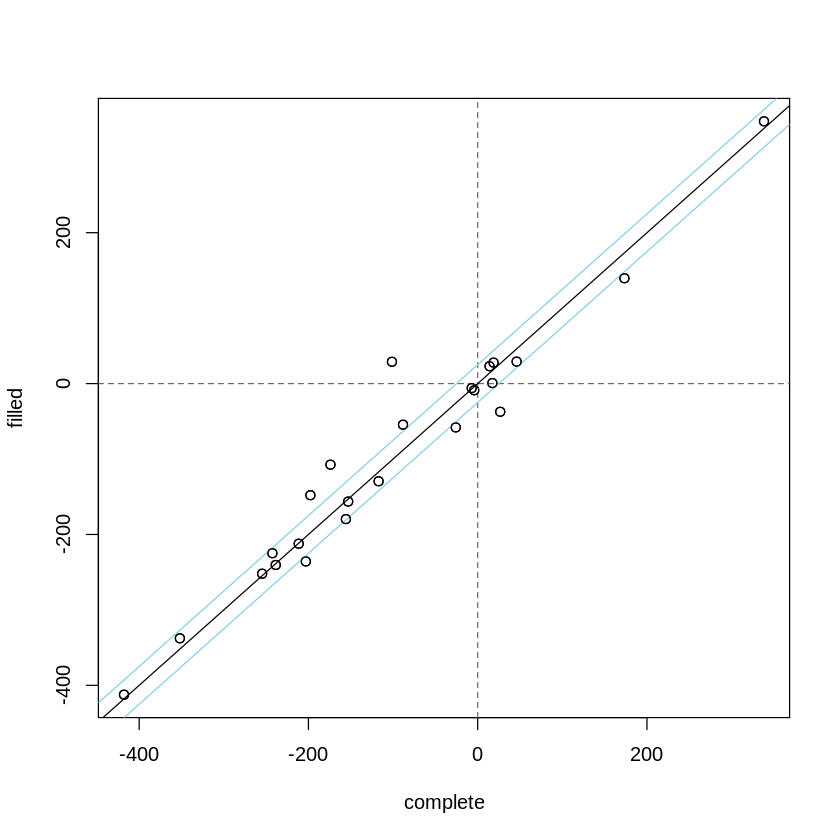

In [39]:
plot(t(res_all[,"alpha_gmst",]))
abline(h = 0, v = 0, lty = 2, col = "dimgrey")

abline(0,1); abline(25,1, col = "skyblue"); abline(-25,1, col = "skyblue")
points(t(res_all[,"alpha_gmst",]))